In [48]:
import os 
from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import AzureOpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import ChatPromptTemplate
from typing import Annotated, Sequence, Literal, List
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
from langchain_community.tools.tavily_search import TavilySearchResults
from langsmith import Client
import langchainhub as hub
from langchain_core.documents import Document


os.environ['AZURE_OPENAI_API_KEY'] = os.getenv('AZURE_OPENAI_API_KEY')
AZURE_API_ENDPOINT = os.getenv('AZURE_API_ENDPOINT')
AZURE_DEPLOYMENT_NAME = os.getenv('AZURE_DEPLOYMENT_NAME')
AZURE_API_VERSION = os.getenv('AZURE_API_VERSION')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'Corrective-RAG'

client = Client(api_key=LANGCHAIN_API_KEY)
load_dotenv()
llm = AzureChatOpenAI(
    model='gpt-4.1-mini',
    azure_endpoint=AZURE_API_ENDPOINT,
    deployment_name=AZURE_DEPLOYMENT_NAME,
    api_version=AZURE_API_VERSION
)

### Vector DB

###

In [ ]:

urls = [
    "https://docs.langchain.com/oss/python/langgraph/overview",
    "https://docs.langchain.com/oss/python/langgraph/workflows-agents",
    "https://docs.langchain.com/oss/python/langgraph/thinking-in-langgraph"
]

docs = [WebBaseLoader(url).load() for url in urls]

doc_list = [item for subtask in docs for item in subtask]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
docs_splitter = text_splitter.split_documents(doc_list)

embeddings = AzureOpenAIEmbeddings(
    model="text-embedding-3-small",
    azure_endpoint=AZURE_API_ENDPOINT)

vector_store = Chroma.from_documents(docs_splitter, embeddings, collection_name='langgraph')

retriver = vector_store.as_retriever()

langchain_retriver_tool = create_retriever_tool(
    retriver,
    "retriver_vector_db_blog",
    "Search and run information about langgraph"
)

In [ ]:
docs = retriver.invoke('What is langraph')

In [ ]:
'\n'.join(doc.page_content for  doc in docs)

In [6]:
tools = [langchain_retriver_tool]

### Graph agent functions

In [15]:
class AgentState(TypedDict):
    """
    Represents the state of the graph
    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    
    question: str 
    generation: str 
    web_search: str 
    documents: List[str]


In [ ]:
def retrieve(state:AgentState):
    """
    Invokes the agent model to generate a response based on the current state. Given the question, it will decide to retrieve using the retriever tool, or simply end
    Args:
        state(messages): The current state 
    Returns:
        state(dict): New key added to the state, documents, that contains retrived_documents    
    """
    print('---retrieve---')
    question = state['question']
    docs = retriver.invoke(question)
    return {"documents": docs, "question": question}
    

In [41]:
def grade_documents(state:AgentState) -> Literal["generate", "rewrite_prompt"]:
    """Determines whether the retrieved documents are relevant to the question
    
    Args: 
        state (messages): the current state 
    Returns: 
        str: A decision for whether the documents are relevant ot not"""
    
    print("---Check Relevance---")
    
    class grade(BaseModel):
        """
        Binary score for relevance check
        """
        
        binary_score: str = Field(description="Documents are relavance to the question, score 'yes' or 'no'")
        
    llm_with_tool = llm.with_structured_output(grade)
    
    grade_prompt = PromptTemplate(
        template = """You are a grader assessing relevance of a retrieved document to a user question.\n
        Here is the retrived document: \n\n {document} \n\n
        Here is the user question: {question} \n 
        If the document contains keyword(s) or semantic meaing related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question""",
        input_variables = ["document", "question"],
    )
    
    chain = grade_prompt | llm_with_tool 
        
    question = state['question']
    documents = state['documents']
    doc_txt = ' '.join(doc.page_content for doc in state['documents'])
    
    scored_result = chain.invoke({"question": question, "document": doc_txt})

    score = scored_result.binary_score 
    
    web_search = 'no'
    
    if score == 'yes':
        print('---Decision: Docs Relevant---')
    else:
        print("---Decision: Docs not relevant---")
        web_search = 'yes'
    
    return {"documents":documents, "question":question, "web_search": web_search}

In [40]:
def generate(state:AgentState):
    """
    Generate answer
    
    Args:
        state(messages): the current state 
        
    Returns:
        dict: The updated message 
    """
    print("--Generate--")
    prompt = client.pull_prompt("rlm/rag-prompt")
    question = state['question']
    
    #docs = "\n\n".join(doc.page_content for doc in state['documents'])
    documents = state['documents']
    
    chain = prompt | llm | StrOutputParser()
    
    generation = chain.invoke({'context': documents, 'question': question})
    return {"generation": generation, "documents": documents, "question": question} 

In [51]:
def transform_query(state:AgentState):
    print("--transform_query---")
    system = """You are a question re-writer that converts an input question to a better version that is optimized for web search
    Look at the input and try to reason about the underlying semnatic intent/meaning"""
    
    question = state["question"]
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', system),
            (
                'human', "Here is the question:\n\n {question} \n Formulate an improved question"
            ),
        ]
    ) 
    question_rewriter = re_write_prompt | llm | StrOutputParser()
    question = question_rewriter.invoke({"question": question})
    return {"question": question}

In [82]:
def websearch(state:AgentState):
    """
    Web search based on the re-phrased question.
    
    Args:
        state(dict): The current graph state 
    
    Returns:
        state(dict): Updates documents key with appended web results    
    
    """
    print("--websearch---")
    websearch_tool = TavilySearchResults(k=3)
    question = state['question']
    documents = state['documents']
    web_results = websearch_tool.invoke(question)
    web_results_1 = '\n'.join(doc['content'] for doc in web_results)
    documents.append(web_results_1)
    
    return {'documents': documents, "question": question}
    

In [83]:
def decide_to_generate(state:AgentState):
    """Determines whether to generate an answer, or re-generate the question
    Args:
        state(dict): The current state of the graph
    Returns:
        str: Binary decision for next node to call    
    """
    
    print("--Assess graded documents")
    web_search = state['web_search']
    
    if web_search == "yes":
        print('---Decision: All documents are not relevant to question, transform query---')
        return "transform_query"
    else:
        print("--Decision: Generate---")
        return "generate"
    

In [84]:
workflow = StateGraph(AgentState)
workflow.add_node('retrieve', retrieve)
workflow.add_node('grade_documents', grade_documents)
workflow.add_node('generate', generate)
workflow.add_node('transform_query', transform_query)
workflow.add_node('websearch', websearch)

workflow.add_edge(START, 'retrieve')
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate"
    }
)
workflow.add_edge("transform_query", "websearch")
workflow.add_edge("websearch", "generate")

graph = workflow.compile()


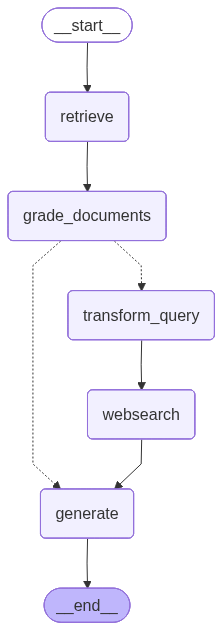

In [85]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [86]:
response = graph.invoke({"question":"What is captial of USA"})

---retrieve---
---Check Relevance---
---Decision: Docs not relevant---
--Assess graded documents
---Decision: All documents are not relevant to question, transform query---
--transform_query---
--websearch---
--Generate--


In [87]:
print(response['generation'])

The capital city of the United States is Washington, D.C. It is a federal district named after George Washington and is located along the Potomac River, bordered by Maryland and Virginia. Washington, D.C. became the capital on July 16, 1790.
